In [3]:
'''
## Overview
This notebook builds ring-attractor network models for zebrafish,
where all connections are inhibitory, and cells only connect to 
a narrow range of other cells (modelled by truncated von Mises).

The input is not only affected by angular head velocity (AHV), but also
increases as the absolute AHV increases. As a result, the activity also
increases, to mimic the experimental observed "jump" of the activity as
the fish went from still to moving.

The notebook is a little bit messy

## Author
Siyuan Mei (mei@bio.lmu.de)

## Last update
2025-9-14
'''
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import pandas as pd

import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *
from HD_utils.exam import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters Set Up

In [7]:
# Simulation theta precision
theta_num = 50
dtheta = (2*np.pi)/theta_num
theta_range = np.arange(-np.pi+dtheta/2, np.pi, dtheta) # must use np.arange(-np.pi+dtheta/2, np.pi, dtheta) to make it symmetry
# Changeable parameters
ring_num = 3
actfun = max0x
weight_fun = vonmises_weight_2i1r_2
search_pars = {'JI': np.linspace(-50,0,6), 'JE': np.linspace(0,50,6), 'K0': np.linspace(-50,0,6), 'kappa': np.logspace(-0.2,1,6)}
file_pre_name = 'new_12'
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
phi = -np.pi * 8/9
tau = 20 # ms
b0 = 1
bc = 1
# Generated parameters
par_num = len(search_pars)
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]
par_names = list(search_pars.keys())
input_num = len(inputs)

# Load Data

In [ ]:
# Run it after the simulation in the current notebook has been saved
network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
    ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)
valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)

Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
    ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]

# Stable

In [10]:
# ---- Need Change
t_max1 = tau * 10 # value must be bigger than 200, if t > t_max1 & network has a bad shape, end simulation
t_max2 = tau * 50 # if t > t_max2, stop simulation, even though network has a good shape
# Routine
network_acvs = np.zeros(search_num, dtype='object')
network_evals= np.ones(search_num, dtype='U30')
network_evaldes = np.zeros(search_num, dtype='object')
network_pars = np.zeros((search_num, par_num))
network_ts = np.zeros(search_num, dtype='object')

for i, pars in enumerate(tqdm(  list(ParameterGrid(search_pars))  )):
    # --- Need change
    par_list = [pars[par_names[j]] for j in range(par_num)]
    w = weight_fun(*par_list, phi, theta_num)
    ## Routine
    b = steady_inputb_2rr(bc, b0, 0, theta_num)# . actually, bC is not used.
    s0 = net_ini_v2(theta_range, ring_num=3)
    y, t, network_evals[i], network_evaldes[i] = \
        inte_check_sta(net_diff_equa, t_max1, t_max2, s0, w, tau, b, theta_num, actfun)
    # Store values
    network_pars[i] = par_list
    network_acvs[i] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]]) # Order of rings: readout, left, right
    network_ts[i] = t
# save simulation result
store_pickle([network_evals, network_evaldes, network_acvs, network_pars, network_ts], 
['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)

valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)
print(valids_num)

100%|██████████| 1296/1296 [00:55<00:00, 23.35it/s]

390


# Moving

In [5]:
# Initialize store variables
network_eval_moving = np.zeros(( search_num, len(inputs) ), dtype='U30')
network_eval_moving_sum = np.copy(network_evals)
network_vvcor = np.zeros((search_num, ring_num, 2))
network_acvs_moving = np.zeros((search_num, len(inputs)), dtype='object')
network_ts_moving = np.zeros((search_num, len(inputs)), dtype='object')
Vels = np.zeros((search_num, len(inputs), ring_num)) 

for i in tqdm(valid_index_s):
    # parameters and weight ---- Need Change
    w = weight_fun(*network_pars[i], phi, theta_num, theta_range)
    # Routine
    s1 = np.concatenate( [network_acvs[i][0,:,-1], network_acvs[i][1,:,-1], network_acvs[i][2,:,-1]] ) # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        b = steady_inputb_2rr_b_increase(bc, b0, ratiov, theta_num)
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun)
        ## Store values
        network_acvs_moving[i,ratioi] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]]) # Order of rings: readout, left, right
        network_ts_moving[i,ratioi] = t
    ## Examine
    network_eval_moving[i][zeroid] = 'stable moving'
    network_eval_moving_sum[i] = 'valid stationary shape'
    if np.all(network_eval_moving[i] == 'stable moving'):
        network_vvcor[i] = cal_correlation(inputs, Vels[i])
        network_eval_moving_sum[i] = exam_vv_linearity(network_vvcor[i])
## save simulation result
store_pickle([Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum], 
             ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], 
             weight_fun, actfun, file_pre_name)

  0%|          | 0/390 [00:00<?, ?it/s]

100%|██████████| 390/390 [01:10<00:00,  5.55it/s]


In [6]:
stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
valid_index_move = np.where(np.diff(stable_mov_range_id, axis=1) >= 2)[0]
valid_index_whole_move = np.where(np.diff(stable_mov_range_id, axis=1) == 8)[0]
valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]
df = pd.DataFrame([[len(valid_index_s), len(valid_index_move), len(valid_index_whole_move), len(valid_index_linear_move)]]\
                  , columns=['Stationary valid', 'Somehow moves', 'whole range moves', 'whole range linear'], index=[''])
print(df)

  Stationary valid  Somehow moves  whole range moves  whole range linear
               390            321                246                 246


## absv increase

In [7]:
Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
    ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]

uf_mm = np.zeros((4, search_num, len(inputs), ring_num)) # mean_u, max_u, mean_f, max_f
for valid_id in valid_index_linear_move:
    for ratioi, ratiov in enumerate(inputs):
        anet_acv = network_acvs_moving[valid_id, ratioi][:,:,-1] # (ring, cell)
        anet_acv += steady_inputb_2rr_b_increase(bc, b0, ratiov, theta_num).reshape((ring_num, theta_num))
        
        uf_mm[0,valid_id, ratioi] = np.mean(anet_acv, axis=1)
        uf_mm[1,valid_id, ratioi] = np.max(anet_acv, axis=1)
        uf_mm[2,valid_id, ratioi] = np.mean(actfun(anet_acv), axis=1)
        uf_mm[3,valid_id, ratioi] = np.max(actfun(anet_acv), axis=1)

In [8]:
(np.diff(linear_mov_range_id, axis=1) == 8).shape

(1296, 1)

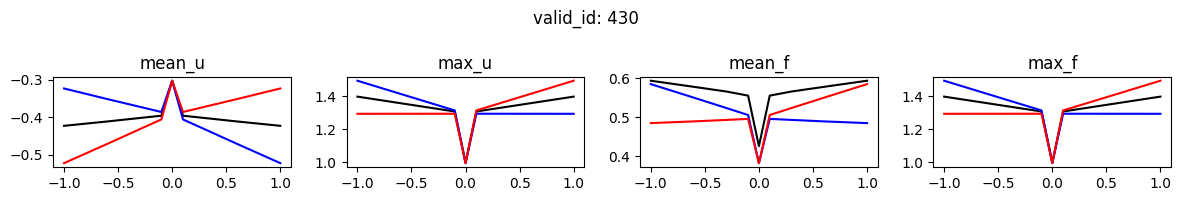

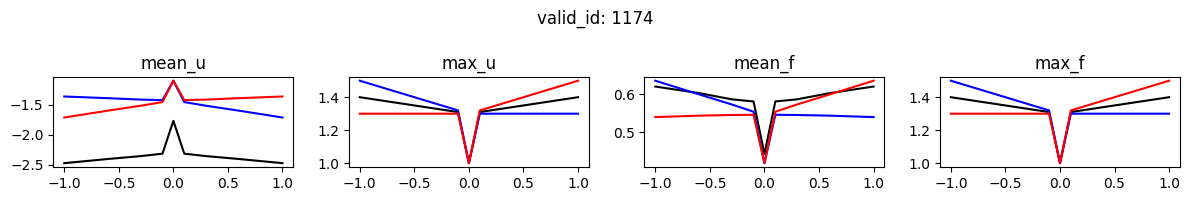

In [10]:
# select id: 1043
a_colors = ['black', 'blue', 'red']
titles = ['mean_u', 'max_u', 'mean_f', 'max_f']

counter = 0
index_vis = np.where( (np.diff(linear_mov_range_id, axis=1) == 8)[:,0] & (network_pars[:, 3] > 5))[0]
for valid_id in index_vis[::50]:
    fig, axes = plt.subplots(1,4, figsize=(12,2))
    fig.suptitle(f'valid_id: {valid_id}')
    for i in range(len(uf_mm)):
        ax = axes[i]
        for ringi in range(ring_num):
            data_plot = uf_mm[i][valid_id].copy()
            fig = ax.plot(inputs, data_plot[:,ringi], color=a_colors[ringi])
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()
    counter += 1
    if counter >= 50:
        break

## Statistics

In [11]:
print_match_result(network_acvs_moving, valid_index_linear_move, zeroid, cal_central_shape_match_loop)

0.00 % = Percent of shape not match
9.60e-08 = Mean[(acv dif) / (max one neighboring acv dif)]
6.43e-06 = SD[(acv dif) / (max one neighboring acv dif)]
9.49e-04 = Max[(acv dif) / (max one neighboring acv dif)]


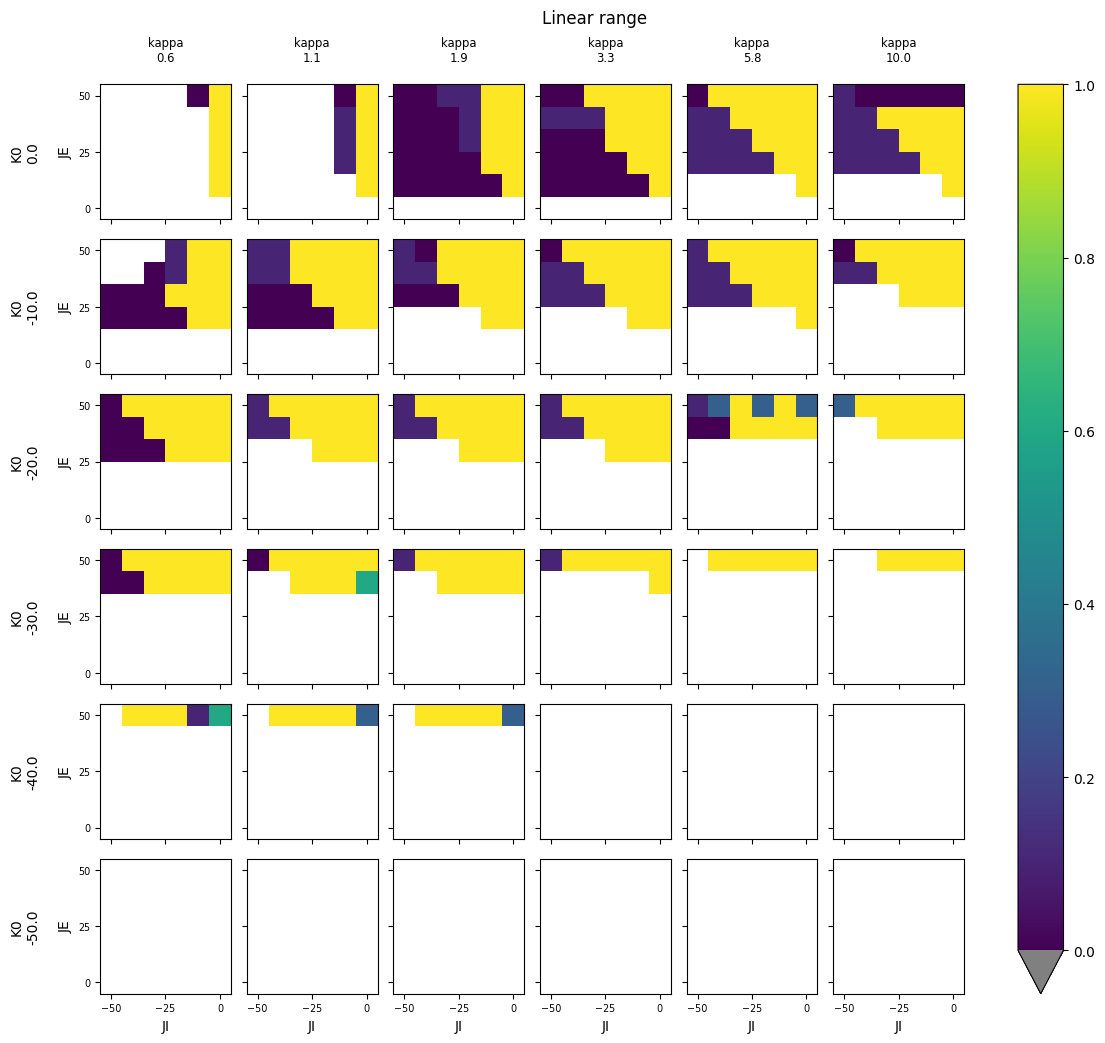

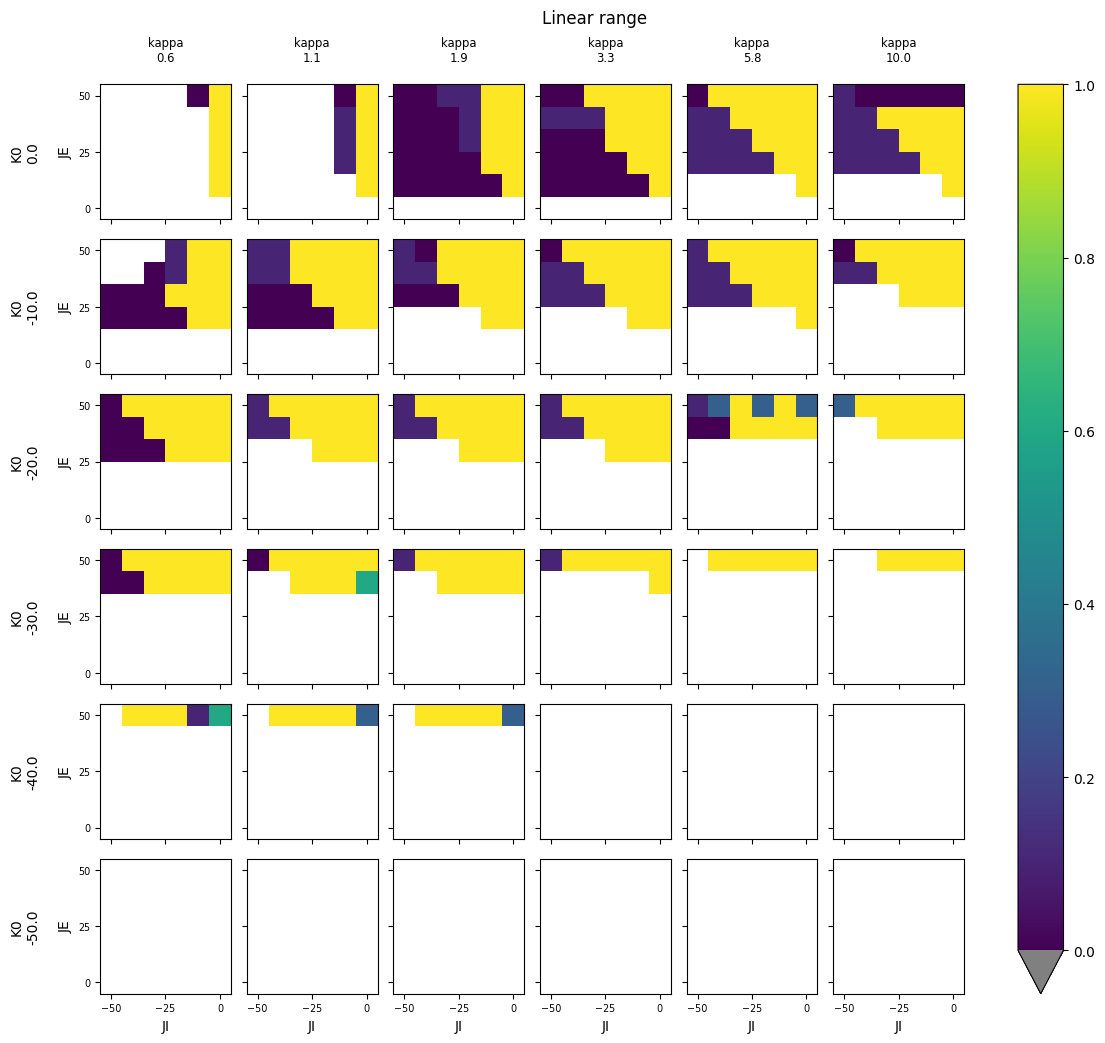

In [12]:
linear_range_plot = oned2colormesh_general(linear_mov_range[:,1], search_pars, network_pars, parnames=par_names)
plot_pars_on_property(linear_range_plot, search_pars, par_names, titles='Linear range')

In [13]:
plot_reverse_rotation(Vels, valid_index_linear_move, inputs, par_names, network_pars)

NUM: Reverse rotation: 246, Forward rotation: 0
Reverse rotation slope: M=-0.340, SD=0.213, Range=[-1.671, -0.144]


peak_acv, mean_acv, peak_firate, mean_firate
0.960 = All Mean[Cor: input - RL diff]
0.274 = All SD[Cor: input - RL diff]
-1.000 = All Min[Cor: input - RL diff]
0.842 = Mean ACV Mean[Cor: input - RL diff]
0.532 = Mean ACV SD[Cor: input - RL diff]
-1.000 = Mean ACV Min[Cor: input - RL diff]


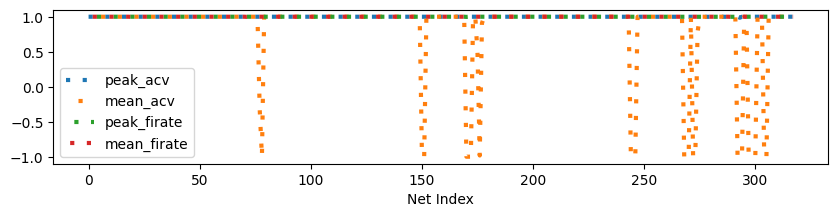

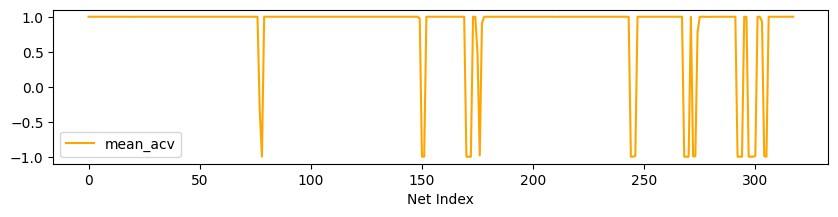

In [15]:
valid_index_part_linear = np.where( linear_mov_range[:,1] > 0 )[0]
bump_amplitudes = cal_firate_a_acv_mean_a_peak(network_acvs_moving, inputs, valid_index_part_linear, [bc,b0], actfun, kind='zebrafish')
input_diff_cors, input_diff_ps = cal_input_diff_cor(inputs, bump_amplitudes[4:], valid_index_part_linear, linear_mov_range_id) 
cor_stat_print_all(input_diff_cors, valid_index_part_linear)
plot_cor(input_diff_cors, valid_index_part_linear)
plot_mean_dif_cor(input_diff_cors, valid_index_part_linear)

# Examine

In [16]:
for i in tqdm(valid_index_linear_move[:1]):
    # parameters and weight ---- Need Change
    w = weight_fun(*network_pars[i], phi, theta_num, theta_range)
    # Routine
    s1 = np.concatenate( [network_acvs[i][0,:,-1], network_acvs[i][1,:,-1], network_acvs[i][2,:,-1]] ) # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        b = steady_inputb_2rr_b_increase(bc, b0, ratiov, theta_num)
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun, theta_range=theta_range, t_max1=10000, t_max2=10500)
        ## Store values
        network_acvs_moving[i,ratioi] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]]) # Order of rings: readout, left, right
        network_ts_moving[i,ratioi] = t

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


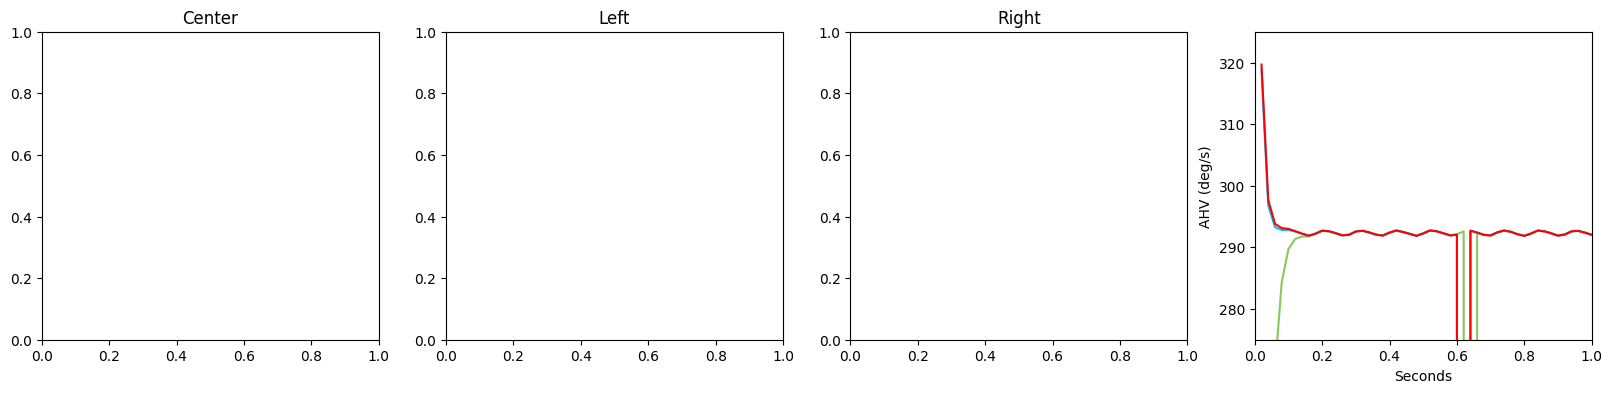

In [17]:
index_vis = valid_index_linear_move
anet = network_acvs_moving[index_vis[0],0]
# anet = network_acvs[index_vis[0]]
fig, axes = plt.subplots(1,4,figsize=(20,4))
names = ['Center', 'Left', 'Right']
colors = [GREENT, 'deepskyblue', 'red']
new_order = [0,2,1]
for ringi in range(3):
    ax = axes[ringi]
    ax.set_title(f'{names[ringi]}')
    pos = []
    for ti in range(anet.shape[-1]):
        a_acv = anet[ringi,:,ti]
        se = a_acv - min(a_acv)
        circular_mean = cstat.mean(theta_range, se, axis=0)
        pos.append(circular_mean)
        
        # ax.plot(theta_range[ringi], anet[ringi,:,ti], label=ti)
    # ax.legend()
    
    ax = axes[3]
    ts = np.arange(tau/1000, tau/1000*(len(pos)-1)+1e-8, tau/1000)
    ax.plot(ts, np.diff(pos)/tau*1000/np.pi*180, label=f'ring {names[ringi]}', c=colors[ringi])
    # ax.plot(ts, np.array(pos[1:])/np.pi*180, label=f'Pos ring {names[ringi]}', c=colors[ringi], alpha=0.5)
    ax.set_ylim(275,325)
    ax.set_ylabel('AHV (deg/s)')
    ax.set_xlabel('Seconds')
    ax.set_xlim(0,1)
    
# axes[3].legend()
plt.show()